In [ ]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# 시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Current working dir:", os.getcwd())

Device: cpu
Current working dir: c:\Users\gram\anaconda3\envs\bmed\bmbd_project


In [ ]:
# 1. 파일 이름 정의

series_file = "GSE30321_series_matrix.txt"   # series matrix
gpl_file    = "GPL13791_data_table.txt"      # 방금 만든 annotation table

In [ ]:
# 2. Qp (cell specific productivity, qproductivity) 파싱

import re
import numpy as np
import pandas as pd

sample_ids = None
qp_values  = None

with open(series_file, "r") as f:
    for line in f:
        line = line.strip()
        
        # 1) 샘플 ID 줄
        if line.startswith("!Sample_geo_accession"):
            parts = line.split("\t")
            sample_ids = [s.strip().strip('"') for s in parts[1:]]
        
        # 2) qproductivity 가 들어있는 characteristics 줄
        elif line.startswith("!Sample_characteristics_ch1") and "qproductivity" in line.lower():
            parts = line.split("\t")[1:]  # 첫 칸은 라벨
            vals = []
            for txt in parts:
                txt = txt.strip().strip('"')
                if ":" in txt:
                    txt = txt.split(":", 1)[1].strip()
                m = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", txt)
                if m:
                    vals.append(float(m.group()))
                else:
                    vals.append(np.nan)
            qp_values = vals
            break  # qproductivity 줄만 찾으면 됨

print("len(sample_ids):", len(sample_ids))
print("len(qp_values):", len(qp_values))

qp_series = pd.Series(qp_values, index=sample_ids, name="Qp")
print(qp_series.head(10))
print("NaN 개수:", qp_series.isna().sum())

len(sample_ids): 295
len(qp_values): 295
GSM751629     NaN
GSM751630     NaN
GSM751631     NaN
GSM751632     NaN
GSM751633     NaN
GSM751634     NaN
GSM751635    45.3
GSM751636    48.2
GSM751637    47.0
GSM751638    35.4
Name: Qp, dtype: float64
NaN 개수: 126


In [ ]:
# 3. expression matrix 읽기 + probe → gene symbol 변환

# series matrix: 행 = probe ID, 열 = 샘플
raw_expr = pd.read_csv(
    series_file,
    sep="\t",
    comment="!",
    index_col=0
)

# GPL13791 annotation: ID, Gene Symbol 포함
gpl = pd.read_csv(
    gpl_file,
    sep="\t",
    comment="#"      # <- 맨 위 #ID= ... 줄 무시
)

gpl.columns = gpl.columns.str.strip()
gpl = gpl[["ID", "Gene Symbol"]].copy()
gpl = gpl.dropna(subset=["Gene Symbol"])
gpl = gpl[gpl["Gene Symbol"] != "NA"]

probe_to_symbol = gpl.set_index("ID")["Gene Symbol"].to_dict()

# probe 단위 → gene symbol 단위
raw_expr_gene = raw_expr.copy()
raw_expr_gene["GeneSymbol"] = raw_expr_gene.index.map(probe_to_symbol)
raw_expr_gene = raw_expr_gene.dropna(subset=["GeneSymbol"])

expr_gene = raw_expr_gene.groupby("GeneSymbol").mean()

# 최종 expr_df : 샘플 × gene
expr_df = expr_gene.T
expr_df.index.name = "sample_id"
expr_df.index = expr_df.index.str.strip().str.replace('"', "")

print("expr_df (sample x gene) shape:", expr_df.shape)
print("예시 gene:", expr_df.columns[:10].tolist())

expr_df (sample x gene) shape: (295, 1776)
예시 gene: ['1110002B05Rik', '1110015K06Rik', '1110020G09Rik', '1200007B05Rik', '1700034H14Rik', '1700081L11Rik', '1810007M14Rik', '1810030O07Rik', '1810044A24Rik', '1810064F22Rik']


In [ ]:
# 4. Qp와 expression의 공통 샘플 맞추기

common_samples = expr_df.index.intersection(qp_series.index)
expr_df = expr_df.loc[common_samples].copy()
qp_series = qp_series.loc[common_samples].copy()

print("Final samples:", expr_df.shape[0])

Final samples: 295


In [ ]:
# 5. Qp 기반 high / low 라벨 (상/하 30%)

valid_mask = qp_series.notna()
qp_valid   = qp_series[valid_mask]
expr_valid = expr_df.loc[qp_valid.index]

print("NaN 아닌 샘플 수:", len(qp_valid))

q_low  = qp_valid.quantile(0.3)
q_high = qp_valid.quantile(0.7)
print("q_low:", q_low, "q_high:", q_high)

mask_low  = qp_valid <= q_low
mask_high = qp_valid >= q_high
mask_keep = mask_low | mask_high

expr_sub = expr_valid.loc[mask_keep].copy()
qp_sub   = qp_valid.loc[mask_keep].copy()

y_bin = (qp_sub >= q_high).astype(int)
print("num low producers:", (y_bin == 0).sum())
print("num high producers:", (y_bin == 1).sum())
print("expr_sub shape:", expr_sub.shape)

NaN 아닌 샘플 수: 169
q_low: 6.72 q_high: 22.9
num low producers: 51
num high producers: 52
expr_sub shape: (103, 1776)


In [ ]:
# 3. 로그 변환 + Z-score scaling + 상위 변동성 유전자 선택

# 이미 log 값이면 log1p 안 해도 됨. 애매하면 log1p 써도 무방.
X_log = np.log1p(expr_sub.values)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

X_scaled_df = pd.DataFrame(
    X_scaled,
    index=expr_sub.index,
    columns=expr_sub.columns
)

# 상위 변동성 유전자만 (예: 5000개. 실제 gene 수보다 작게 설정)
gene_var = X_scaled_df.var(axis=0)
top_k = min(5000, X_scaled_df.shape[1])
top_genes = gene_var.sort_values(ascending=False).head(top_k).index

X_top = X_scaled_df[top_genes].copy()

print("X_top shape:", X_top.shape)

X_top shape: (103, 1776)


In [ ]:
print("X_scaled_df columns 예시:", X_scaled_df.columns[:10].tolist())
print("컬럼 개수:", len(X_scaled_df.columns))

X_scaled_df columns 예시: ['1110002B05Rik', '1110015K06Rik', '1110020G09Rik', '1200007B05Rik', '1700034H14Rik', '1700081L11Rik', '1810007M14Rik', '1810030O07Rik', '1810044A24Rik', '1810064F22Rik']
컬럼 개수: 1776


In [ ]:
# 4. UPR / Secretory gene set 점수 계산

PRO_SURVIVAL_GENES = [
    "HSPA5", "HSP90B1", "PDIA4", "PDIA3", "PDIA6", "XBP1", "ATF6"
]

PRO_APOPTOTIC_GENES = [
    "DDIT3", "BBC3", "BAX", "PMAIP1"
]

SECRETORY_GENES = [
    "SEC61A1", "SEC24D", "SAR1A", "EDEM1", "HERPUD1", "HYOU1"
]

def intersect_genes(gene_list, columns):
    return [g for g in gene_list if g in columns]

survival_genes   = intersect_genes(PRO_SURVIVAL_GENES, X_scaled_df.columns)
apoptotic_genes  = intersect_genes(PRO_APOPTOTIC_GENES, X_scaled_df.columns)
secretory_genes  = intersect_genes(SECRETORY_GENES, X_scaled_df.columns)

print("Survival genes used:", survival_genes)
print("Apoptotic genes used:", apoptotic_genes)
print("Secretory genes used:", secretory_genes)

def gene_set_score(df, genes):
    if len(genes) == 0:
        return pd.Series(0.0, index=df.index)
    return df[genes].mean(axis=1)

survival_score  = gene_set_score(X_scaled_df, survival_genes)
apoptotic_score = gene_set_score(X_scaled_df, apoptotic_genes)
secretory_score = gene_set_score(X_scaled_df, secretory_genes)

upr_balance = survival_score - apoptotic_score

pathway_feat = pd.DataFrame({
    "upr_survival": survival_score,
    "upr_apoptotic": apoptotic_score,
    "upr_balance": upr_balance,
    "secretory": secretory_score,
}, index=X_scaled_df.index)

# 고/저생산 서브셋에 맞게
pathway_feat = pathway_feat.loc[expr_sub.index]
pathway_feat.head()

Survival genes used: ['HSP90B1', 'PDIA4', 'PDIA6']
Apoptotic genes used: ['DDIT3']
Secretory genes used: ['SEC24D', 'HERPUD1', 'HYOU1']


,upr_survival,upr_apoptotic,upr_balance,secretory
GSM751635,0.180922,-0.096607,0.277529,0.524675
GSM751636,0.455325,-0.139309,0.594634,0.766122
GSM751637,0.071089,-0.191192,0.262281,0.412323
GSM751638,-0.098628,-0.848739,0.750111,0.120581
GSM751639,-0.587966,-0.131143,-0.456823,-0.065400


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score

# K-fold cross-validation (Pathway features)

# pathway_feat, expr_sub, y_bin 은 이미 앞에서 만든 상태라고 가정
X_path = pathway_feat.loc[expr_sub.index].values  # (n_samples, 4)
y_path = y_bin.values                             # (n_samples,)

clf = LogisticRegression(max_iter=1000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs = cross_val_score(clf, X_path, y_path, cv=cv, scoring="accuracy")
aucs = cross_val_score(clf, X_path, y_path, cv=cv, scoring="roc_auc")

print("==== 5-fold CV (Pathway LR) ====")
print("Fold accuracies:", accs)
print("Mean acc  = {:.3f} ± {:.3f}".format(accs.mean(), accs.std()))
print("Fold AUCs :", aucs)
print("Mean AUC  = {:.3f} ± {:.3f}".format(aucs.mean(), aucs.std()))

==== 5-fold CV (Pathway LR) ====
Fold accuracies: [0.9047619  0.80952381 0.80952381 0.75       0.75      ]
Mean acc  = 0.805 ± 0.057
Fold AUCs : [0.88181818 0.91818182 0.90909091 0.77       0.79      ]
Mean AUC  = 0.854 ± 0.062


In [ ]:
# 여러 random_state로 train/test split 반복

X_path = pathway_feat.loc[expr_sub.index].values
y_path = y_bin.values

seeds = range(10)   # 0 ~ 9 까지 10번 반복 (원하면 20, 50 등으로 늘려도 됨)

acc_list = []
auc_list = []

for seed in seeds:
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
        X_path, y_path,
        test_size=0.2,
        random_state=seed,
        stratify=y_path
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_p, y_train_p)

    y_proba = clf.predict_proba(X_test_p)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y_test_p, y_pred)
    auc = roc_auc_score(y_test_p, y_proba)

    acc_list.append(acc)
    auc_list.append(auc)

    print(f"[split seed={seed:02d}] acc={acc:.3f}, auc={auc:.3f}")

print("==== Random split summary (Pathway LR) ====")
print("Accuracy mean ± std: {:.3f} ± {:.3f}".format(np.mean(acc_list), np.std(acc_list)))
print("AUC      mean ± std: {:.3f} ± {:.3f}".format(np.mean(auc_list), np.std(auc_list)))

[split seed=00] acc=0.810, auc=0.909
[split seed=01] acc=0.857, auc=0.927
[split seed=02] acc=0.810, auc=0.900
[split seed=03] acc=0.857, auc=0.955
[split seed=04] acc=0.810, auc=0.873
[split seed=05] acc=0.762, auc=0.773
[split seed=06] acc=0.905, auc=0.927
[split seed=07] acc=0.762, auc=0.727
[split seed=08] acc=0.762, auc=0.945
[split seed=09] acc=0.762, auc=0.873
==== Random split summary (Pathway LR) ====
Accuracy mean ± std: 0.810 ± 0.048
AUC      mean ± std: 0.881 ± 0.071


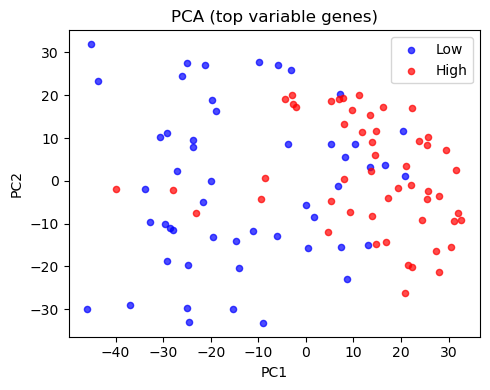

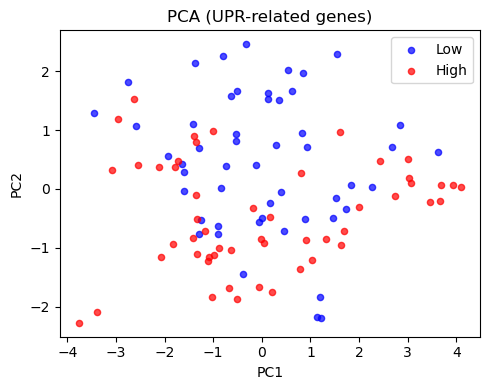

In [ ]:
# 5. PCA 시각화 (전체 top_genes vs UPR genes)

y = y_bin.values

# (a) 상위 변동성 유전자 전체
pca_all = PCA(n_components=2)
X_pca_all = pca_all.fit_transform(X_top.values)

# (b) UPR 관련 유전자만
upr_genes_all = list(set(survival_genes + apoptotic_genes + secretory_genes))
X_upr = X_scaled_df[upr_genes_all].loc[expr_sub.index]
pca_upr = PCA(n_components=2)
X_pca_upr = pca_upr.fit_transform(X_upr.values)

def plot_pca(X_2d, labels, title):
    plt.figure(figsize=(5,4))
    for cls, color, name in [(0, "blue", "Low"), (1, "red", "High")]:
        mask = (labels == cls)
        plt.scatter(X_2d[mask,0], X_2d[mask,1], s=20, alpha=0.7, label=name, c=color)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca(X_pca_all, y, "PCA (top variable genes)")
plot_pca(X_pca_upr, y, "PCA (UPR-related genes)")

In [ ]:
# 6. Fully-connected Autoencoder 정의 (MNIST AE 구조 응용)

class FCAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2, hidden_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

input_dim = X_top.shape[1]
LATENT_DIM = 2
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-3

ae_model = FCAutoencoder(input_dim=input_dim, latent_dim=LATENT_DIM).to(device)
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=LR)
ae_criterion = nn.MSELoss()

X_tensor = torch.from_numpy(X_top.values).float()
ae_dataset = TensorDataset(X_tensor)
ae_loader = DataLoader(ae_dataset, batch_size=BATCH_SIZE, shuffle=True)

def ae_train_one_epoch(model, loader, optimizer, device, criterion):
    model.train()
    total_loss = 0.0
    for (xb,) in loader:
        xb = xb.to(device)
        optimizer.zero_grad()
        recon, _ = model(xb)
        loss = criterion(recon, xb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

for epoch in range(1, EPOCHS+1):
    train_loss = ae_train_one_epoch(ae_model, ae_loader, ae_optimizer, device, ae_criterion)
    if epoch % 10 == 0 or epoch == 1:
        print(f"[AE Epoch {epoch:02d}] loss = {train_loss:.4f}")

[AE Epoch 01] loss = 1.0485
[AE Epoch 10] loss = 0.6265
[AE Epoch 20] loss = 0.5671
[AE Epoch 30] loss = 0.5272
[AE Epoch 40] loss = 0.4992
[AE Epoch 50] loss = 0.4782


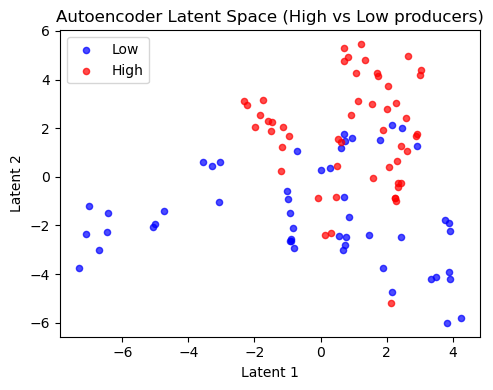

In [ ]:
ae_model.eval()
with torch.no_grad():
    X_tensor_all = X_tensor.to(device)
    _, Z_all = ae_model(X_tensor_all)
    Z_all = Z_all.cpu().numpy()

# expr_sub 인덱스에 해당하는 latent만 선택
Z_df = pd.DataFrame(Z_all, index=X_top.index, columns=[f"z{i+1}" for i in range(LATENT_DIM)])
Z_sub = Z_df.loc[expr_sub.index].values

plt.figure(figsize=(5,4))
for cls, color, name in [(0, "blue", "Low"), (1, "red", "High")]:
    mask = (y == cls)
    plt.scatter(Z_sub[mask,0], Z_sub[mask,1], s=20, alpha=0.7, label=name, c=color)
plt.xlabel("Latent 1"); plt.ylabel("Latent 2")
plt.title("Autoencoder Latent Space (High vs Low producers)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 7. 분류 모델: pathway-level feature

X_path = pathway_feat.loc[expr_sub.index].values
y_path = y

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_path, y_path, test_size=0.2, random_state=42, stratify=y_path
)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_p, y_train_p)   # resampled 데이터 사용
#log_reg.fit(X_train_res, y_train_res)

y_pred_p = log_reg.predict(X_test_p)
y_proba_p = log_reg.predict_proba(X_test_p)[:,1]

print("Pathway-level Logistic Regression")
print("Accuracy:", accuracy_score(y_test_p, y_pred_p))
print("ROC-AUC:", roc_auc_score(y_test_p, y_proba_p))
print(classification_report(y_test_p, y_pred_p))

Pathway-level Logistic Regression
Accuracy: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



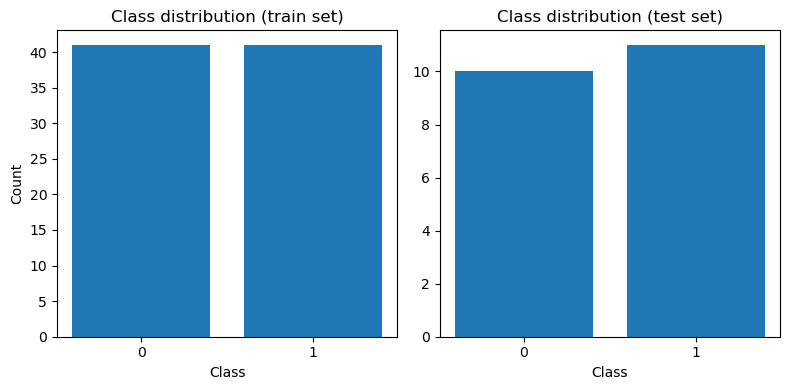

In [ ]:
# 7-1. 클래스 분포 (원본 train/test)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

train_counts = pd.Series(y_train_p).value_counts().sort_index()
test_counts  = pd.Series(y_test_p).value_counts().sort_index()

axes[0].bar(train_counts.index.astype(str), train_counts.values)
axes[0].set_title("Class distribution (train set)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

axes[1].bar(test_counts.index.astype(str), test_counts.values)
axes[1].set_title("Class distribution (test set)")
axes[1].set_xlabel("Class")

plt.tight_layout()
plt.show()

ROC AUC (pathway LR, single split): 1.0


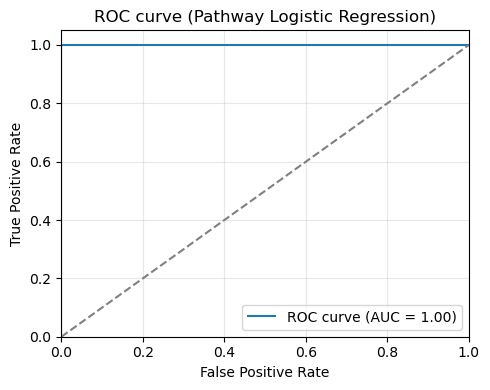

In [ ]:
# 7-3. ROC curve

fpr, tpr, thresholds = roc_curve(y_test_p, y_proba_p)
roc_auc = roc_auc_score(y_test_p, y_proba_p)

print("ROC AUC (pathway LR, single split):", roc_auc)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Pathway Logistic Regression)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

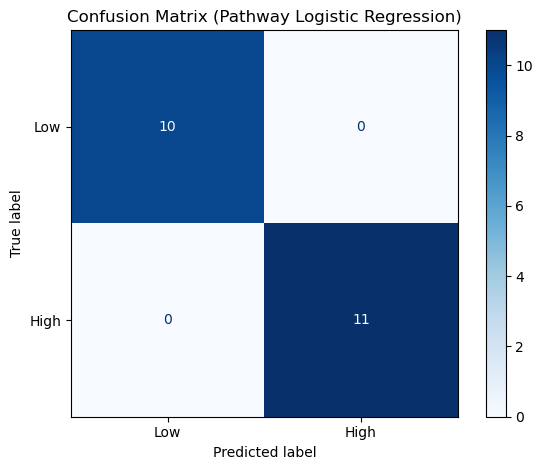

In [ ]:
# 7-4. Confusion matrix

cm = confusion_matrix(y_test_p, y_pred_p, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Low", "High"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Pathway Logistic Regression)")
plt.tight_layout()
plt.show()

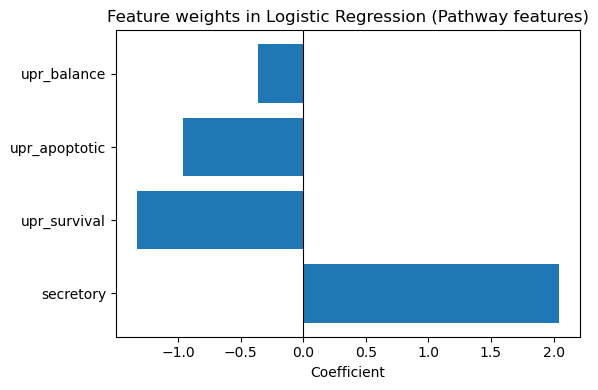

In [ ]:
# 7-5. Feature weights (logistic 회귀 계수)

feature_names = pathway_feat.columns.to_numpy()  # ["upr_survival", "upr_apoptotic", "upr_balance", "secretory"]
coefs = log_reg.coef_[0]  # binary classification이므로 첫 번째 row 사용

# 계수 절댓값 기준으로 큰 순서대로 정렬
order = np.argsort(np.abs(coefs))[::-1]

plt.figure(figsize=(6, 4))
plt.barh(range(len(coefs)), coefs[order])
plt.yticks(range(len(coefs)), feature_names[order])
plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Coefficient")
plt.title("Feature weights in Logistic Regression (Pathway features)")
plt.tight_layout()
plt.show()

In [ ]:
perc = Perceptron()
perc.fit(X_train_p, y_train_p)
y_pred_perc = perc.predict(X_test_p)
print("Perceptron Accuracy:", accuracy_score(y_test_p, y_pred_perc))

Perceptron Accuracy: 0.7142857142857143
